In [ ]:
from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, classification_report, precision_score, recall_score, f1_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

In [ ]:
!wget -O fetal_health.csv https://raw.githubusercontent.com/b0bhat/colab-data/main/fetal_health.csv
df = pd.read_csv("fetal_health.csv")
df.head()

--2024-03-14 00:45:19--  https://raw.githubusercontent.com/b0bhat/colab-data/main/fetal_health.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228715 (223K) [text/plain]
Saving to: ‘fetal_health.csv’

fetal_health.csv    100%[===================>] 223.35K  --.-KB/s    in 0.02s   

2024-03-14 00:45:19 (13.0 MB/s) - ‘fetal_health.csv’ saved [228715/228715]



,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


Training accuracy (MLP): 0.9358006042296072
Test accuracy (MLP): 0.905337361530715


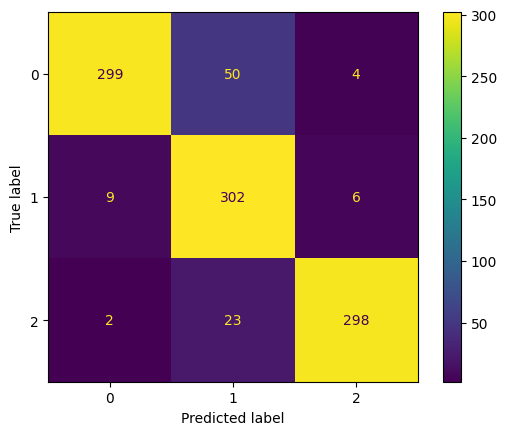

In [ ]:
allfeatures = df.columns
dropped = ['fetal_health', 'histogram_min', 'histogram_min', 'histogram_max', 'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance', 'histogram_tendency']

X = df.drop(columns=dropped)
y = df["fetal_health"]

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# split into train n test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_clf.fit(X_train_pca, y_train)

y_train_pred_mlp = mlp_clf.predict(X_train_pca)
y_test_pred_mlp = mlp_clf.predict(X_test_pca)

train_accuracy_mlp = accuracy_score(y_train, y_train_pred_mlp)
test_accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)

ConfusionMatrixDisplay(cm_mlp).plot()
print("Training accuracy (MLP):", train_accuracy_mlp)
print("Test accuracy (MLP):", test_accuracy_mlp)

In [ ]:
X = df.drop(columns=dropped)
y = df["fetal_health"]-1

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

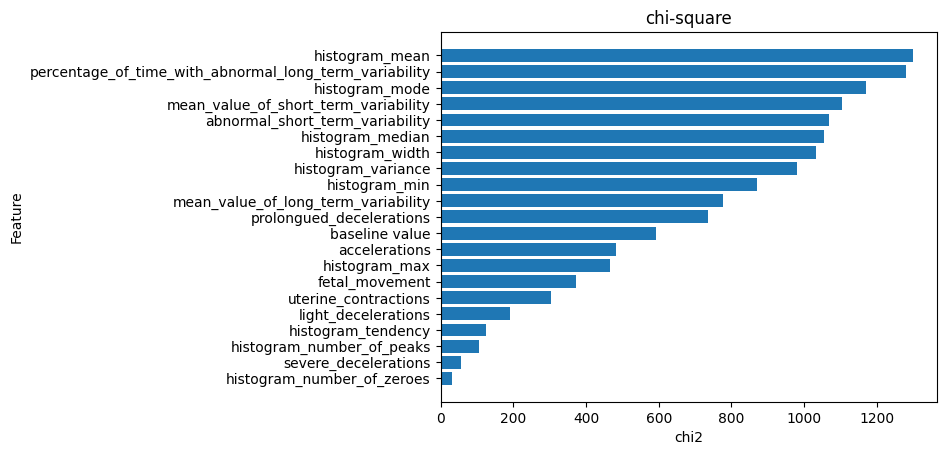

In [ ]:
from scipy.stats import chi2_contingency
X = df.drop(columns='fetal_health')

contingency_tables = []
for column in X.columns:
    contingency_table = pd.crosstab(X[column], df['fetal_health'])
    contingency_tables.append((column, contingency_table))

results = []
for column, contingency_table in contingency_tables:
    chi2, p, _, _ = chi2_contingency(contingency_table)
    results.append((column, chi2, p))

results.sort(key=lambda x: x[1])

feature_names = [result[0] for result in results]
chi2v = [result[1] for result in results]

plt.barh(feature_names, chi2v)
plt.xlabel('chi2')
plt.ylabel('Feature')
plt.title('chi-square')
plt.show()

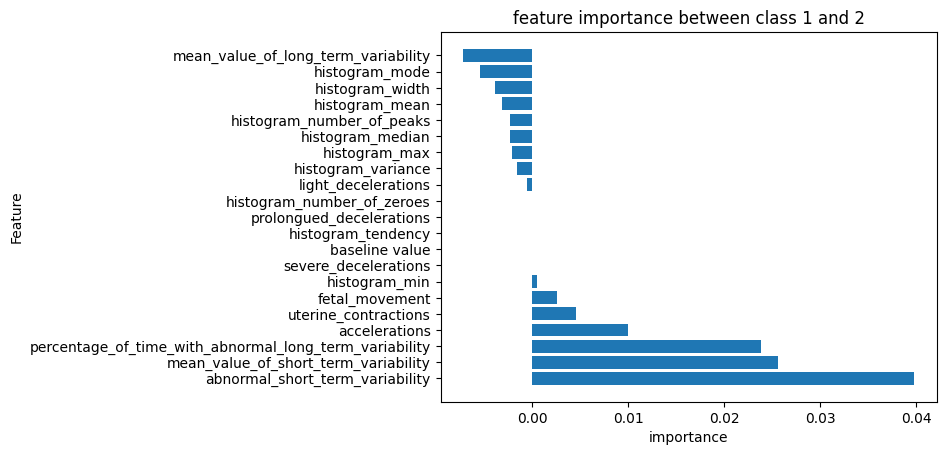

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import pandas as pd

df_filtered = df[df['fetal_health'].isin([1, 2])]
y = df_filtered['fetal_health']
df_filtered = df_filtered.drop(columns='fetal_health')

X_train, X_test, y_train, y_test = train_test_split(df_filtered, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_importance_df = pd.DataFrame({'Feature': df_filtered.columns, 'Importance': perm_importance.importances_mean})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('importance')
plt.ylabel('Feature')
plt.title('feature importance between class 1 and 2')
plt.show()


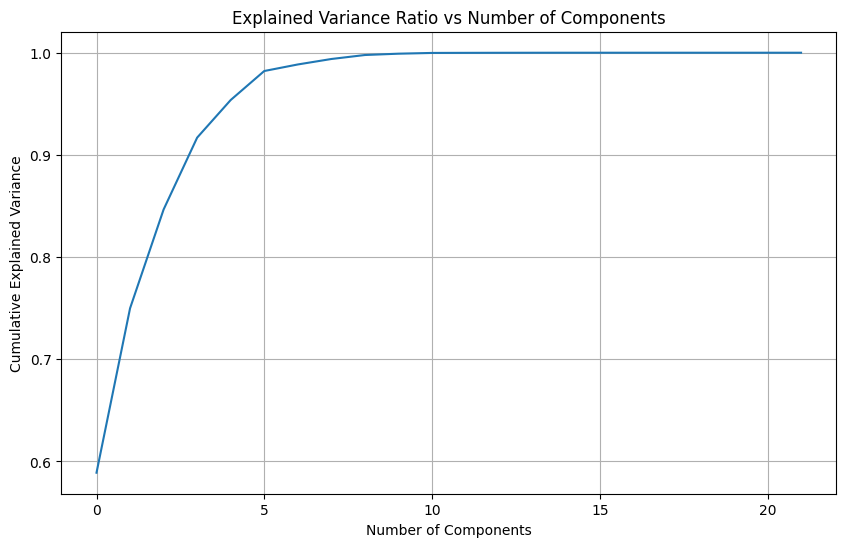

In [ ]:
pca = PCA()
pca.fit(df)

# Plotting explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio vs Number of Components')
plt.grid(True)
plt.show()

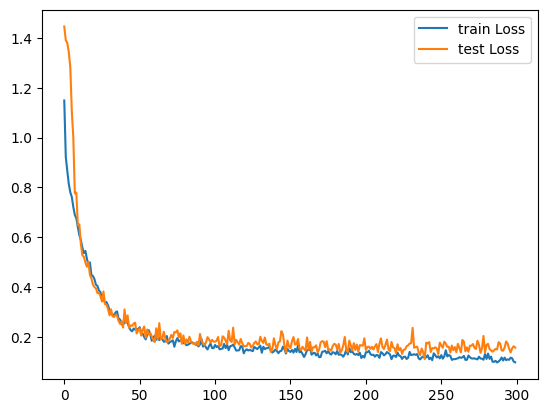

39/39 [==============================] - 0s 2ms/step
Training accuracy (Neural Network): 0.986569970453935
Test accuracy (Neural Network): 0.964573268921095
Train balanced acc: 0.98646233040845
Test balanced acc: 0.9652456747684862

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       433
         1.0       0.94      0.96      0.95       404
         2.0       0.98      1.00      0.99       405

    accuracy                           0.96      1242
   macro avg       0.96      0.97      0.96      1242
weighted avg       0.97      0.96      0.96      1242



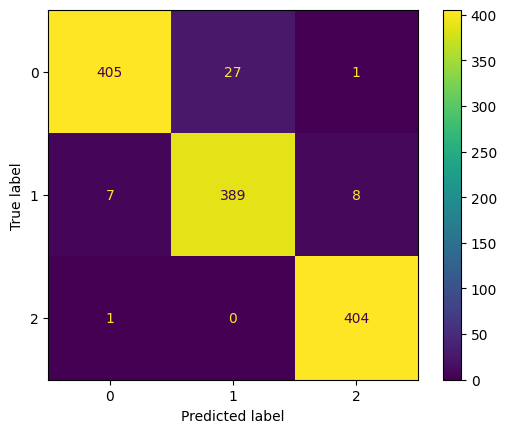

In [ ]:
allfeatures = df.columns
# dropped = ['fetal_health', 'histogram_width', 'histogram_max', 'histogram_min', 'histogram_median', 'histogram_mean', 'histogram_mode', 'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_tendency']
dropped = [
    'fetal_health', 'baseline value', 'histogram_width',
    'light_decelerations', 'severe_decelerations', 'histogram_median',
    'histogram_mode', 'histogram_number_of_peaks',
    'histogram_number_of_zeroes', 'histogram_tendency', 'fetal_movement',
    'histogram_max', 'fetal_movement',
    ]

X = df.drop(columns=dropped)
y = df['fetal_health']-1

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# pca = PCA(n_components=6)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weight_dict = dict(enumerate(class_weights))

reg_loss = 0.001
dropout = 0.1
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(reg_loss)),
    BatchNormalization(),
    Dropout(dropout),
    Dense(256, activation='relu', kernel_regularizer=l2(reg_loss)),
    BatchNormalization(),
    Dropout(dropout),
    Dense(128, activation='relu', kernel_regularizer=l2(reg_loss)),
    BatchNormalization(),
    Dropout(dropout),
    Dense(64, activation='relu', kernel_regularizer=l2(reg_loss)),
    BatchNormalization(),
    Dropout(dropout),
    Dense(32, activation='relu', kernel_regularizer=l2(reg_loss)),
    BatchNormalization(),
    Dropout(dropout),
    Dense(3, activation='softmax')
])

sgd = SGD(learning_rate=0.01, momentum=0.9)
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_split=0.2, class_weight=class_weight_dict, verbose=0)
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=64, validation_split=0.25, verbose=0)

plt.plot(history.history['loss'], label='train Loss')
plt.plot(history.history['val_loss'], label='test Loss')
plt.legend()
plt.show()

train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)[1]
test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)[1]

y_train_pred_nn = np.argmax(model.predict(X_train_scaled), axis=-1)
y_test_pred_nn = np.argmax(model.predict(X_test_scaled), axis=-1)

train_accuracy_nn = accuracy_score(y_train, y_train_pred_nn)
test_accuracy_nn = accuracy_score(y_test, y_test_pred_nn)
cm_nn = confusion_matrix(y_test, y_test_pred_nn)

ConfusionMatrixDisplay(cm_nn).plot()

print("Training accuracy:", train_accuracy_nn)
print("Test accurac:", test_accuracy_nn)

balanced_accuracy_train_nn = balanced_accuracy_score(y_train, y_train_pred_nn)
balanced_accuracy_test_nn = balanced_accuracy_score(y_test, y_test_pred_nn)

print("Train balanced acc:", balanced_accuracy_train_nn)
print("Test balanced acc:", balanced_accuracy_test_nn)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_nn))

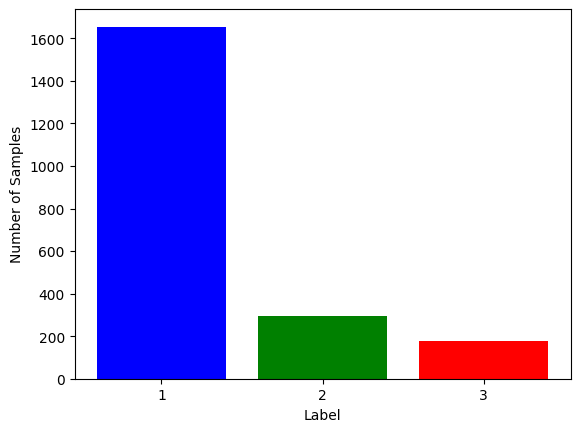

In [ ]:
count_1 = (df['fetal_health'] == 1).sum()
count_2 = (df['fetal_health'] == 2).sum()
count_3 = (df['fetal_health'] == 3).sum()
colors = ['blue', 'green', 'red']
plt.bar([1, 2, 3], [count_1, count_2, count_3], color=colors)
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.xticks([1, 2, 3])
plt.show()